<a href="https://colab.research.google.com/github/visionNoob/Tensorflow_Tutorial/blob/master/Day_3/fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
import time
import shutil

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import applications

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

tf.enable_eager_execution()
tf.set_random_seed(42)
np.random.seed(42)
tf.__version__

'1.14.0'

In [0]:
conv_base = tf.keras.applications.VGG16(weights='imagenet',
                                        include_top=False,
                                        input_shape=(150,150,3))

In [3]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [4]:
model = tf.keras.Sequential()
model.add(conv_base)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(5, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1285      
Total params: 16,813,381
Trainable params: 16,813,381
Non-trainable params: 0
_________________________________________________________________


In [5]:
# Freeze vgg16 conv base part (means that trainable option is False)
for layer in model.layers:
  if layer.name == 'vgg16':
    layer.trainable = False
  print("variable name: {}, trainable: {}".format(layer.name, layer.trainable))

# also 
#conv_base.trainable = False

variable name: vgg16, trainable: False
variable name: flatten, trainable: True
variable name: dense, trainable: True
variable name: dense_1, trainable: True


In [6]:
# I upload zip file on my dropbox
# if you want to download from my dropbox uncomment below  
DATASET_PATH='./flower'
  
if not os.path.isdir(DATASET_PATH):
  os.makedirs(DATASET_PATH)
  
  import urllib.request
  u = urllib.request.urlopen(url='https://www.dropbox.com/s/1tqczockfgdnz8z/flower.zip?dl=1')
  data = u.read()
  u.close()
 
  with open('flower.zip', "wb") as f :
    f.write(data)
  print('Data has been downloaded')
  
  shutil.move(os.path.join('flower.zip'), os.path.join(DATASET_PATH))
  file_path = os.path.join(DATASET_PATH, 'flower.zip')
  
  import zipfile
  zip_ref = zipfile.ZipFile(file_path, 'r')
  zip_ref.extractall(DATASET_PATH)
  zip_ref.close()
  print('Data has been extracted.')
  
else:
  print('Data has already been downloaded and extracted.')

Data has been downloaded
Data has been extracted.


In [7]:
base_dir = os.path.join(DATASET_PATH, 'flower')

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

print(train_dir)
print(validation_dir)
print(test_dir)

./flower/flower/train
./flower/flower/validation
./flower/flower/test


In [10]:
class_name = sorted(os.listdir(train_dir))
for name in class_name:
  print(name)

daisy
dandelion
roses
sunflowers
tulips


In [11]:
num_train = 0
num_val = 0
num_test = 0
for name in class_name:
  train_path = os.path.join(train_dir, name)
  val_path = os.path.join(validation_dir, name)
  test_path = os.path.join(test_dir, name)
  print("Number of {} class: for train: {} / for validation: {} / for test: {}".format(name,
                                                                len(os.listdir(train_path)),
                                                                len(os.listdir(val_path)),
                                                                len(os.listdir(train_path))))
  num_train += len(os.listdir(train_path))
  num_val += len(os.listdir(val_path))
  num_test += len(os.listdir(test_path))

print('--------')
print("Total training images:", num_train)
print("Total validation images:", num_val)
print("Total test images:", num_test)

Number of daisy class: for train: 534 / for validation: 32 / for test: 534
Number of dandelion class: for train: 717 / for validation: 61 / for test: 717
Number of roses class: for train: 539 / for validation: 23 / for test: 539
Number of sunflowers class: for train: 577 / for validation: 27 / for test: 577
Number of tulips class: for train: 642 / for validation: 49 / for test: 642
--------
Total training images: 3009
Total validation images: 192
Total test images: 469


In [0]:
batch_size = 512

In [0]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [23]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

Found 3009 images belonging to 5 classes.


In [24]:
val_generator = val_datagen.flow_from_directory(validation_dir,
                                                target_size=(150, 150),
                                                batch_size=batch_size,
                                                class_mode='categorical')

Found 192 images belonging to 5 classes.


In [25]:
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(150, 150),
                                                  batch_size=batch_size,
                                                  class_mode='categorical')

Found 469 images belonging to 5 classes.


In [0]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=3)

In [28]:
epoch = 10

history = model.fit_generator(
    train_generator,
    steps_per_epoch=int(np.ceil(num_train / float(batch_size))),
    epochs=epoch,
    validation_data=val_generator,
    validation_steps=int(np.ceil(num_val / float(batch_size))),
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/10
6/6 [==============================] - 51s 9s/step - loss: 0.8200 - acc: 0.7029 - val_loss: 0.8222 - val_acc: 0.6302
Epoch 2/10
6/6 [==============================] - 32s 5s/step - loss: 0.6693 - acc: 0.7484 - val_loss: 0.6596 - val_acc: 0.7500
Epoch 3/10
6/6 [==============================] - 37s 6s/step - loss: 0.5958 - acc: 0.7827 - val_loss: 0.6521 - val_acc: 0.7604
Epoch 4/10
6/6 [==============================] - 37s 6s/step - loss: 0.5785 - acc: 0.7906 - val_loss: 0.7043 - val_acc: 0.7552
Epoch 5/10
6/6 [==============================] - 36s 6s/step - loss: 0.5616 - acc: 0.7913 - val_loss: 0.6349 - val_acc: 0.7708
Epoch 6/10
6/6 [==============================] - 36s 6s/step - loss: 0.5390 - acc: 0.8089 - val_loss: 0.6298 - val_acc: 0.7865
Epoch 7/10
6/6 [==============================] - 37s 6s/step - loss: 0.5380 - acc: 0.8076 - val_loss: 0.6215 - val_acc: 0.7812
Epoch 8/10
6/6 [==============================] - 36s 6s/step - loss: 0.5024 - acc: 0.8215 - val_loss: 0

In [29]:
print(history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])


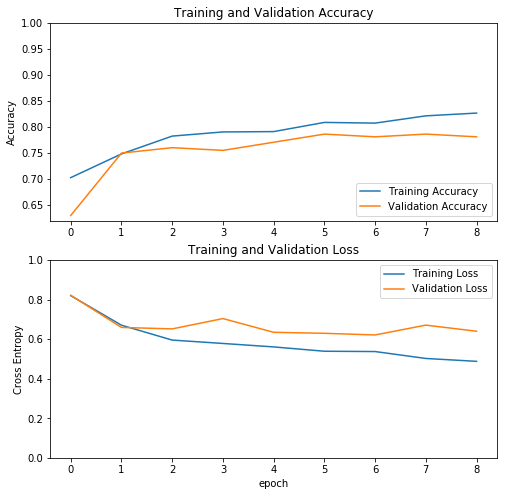

In [32]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()



# Un-freeze the top layers of the model

In [0]:
conv_base.trainable = True

In [39]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(conv_base.layers))

# Fine tune from this layer onwards
fine_tune_at = 4

# Freeze all the layers before the `fine_tune_at` layer
for layer in conv_base.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  19


In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1285      
Total params: 16,813,381
Trainable params: 2,098,693
Non-trainable params: 14,714,688
_________________________________________________________________


In [41]:
epoch = 3

history = model.fit_generator(
    train_generator,
    steps_per_epoch=int(np.ceil(num_train / float(batch_size))),
    epochs=epoch,
    validation_data=val_generator,
    validation_steps=int(np.ceil(num_val / float(batch_size))),
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/3
6/6 [==============================] - 36s 6s/step - loss: 0.4767 - acc: 0.8245 - val_loss: 0.6121 - val_acc: 0.7812
Epoch 2/3
6/6 [==============================] - 36s 6s/step - loss: 0.4575 - acc: 0.8352 - val_loss: 0.6003 - val_acc: 0.7656
Epoch 3/3
6/6 [==============================] - 36s 6s/step - loss: 0.4620 - acc: 0.8269 - val_loss: 0.6393 - val_acc: 0.7917


In [0]:
acc += history.history['acc']
val_acc += history.history['val_acc']

loss += history.history['loss']
val_loss += history.history['val_loss']

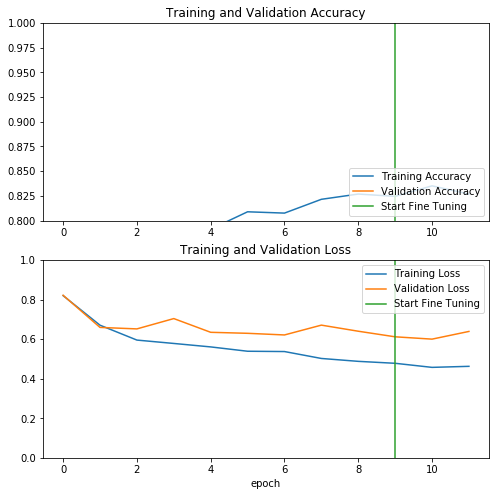

In [45]:
initial_epochs = 10 
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

![대체 텍스트](https://www.tensorflow.org/beta/tutorials/images/transfer_learning_files/output_chW103JUItdk_0.png)